<a href="https://colab.research.google.com/github/remisharoon/QuantumAnalytics/blob/master/NYC_Taxi_Anomaly_Detection_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_232"
OpenJDK Runtime Environment (build 1.8.0_232-8u232-b09-0ubuntu1~18.04.1-b09)
OpenJDK 64-Bit Server VM (build 25.232-b09, mixed mode)


In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diff', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
try:
  from zoo.common.nncontext import *
  sc = init_nncontext("Anomaly Detection Example")
except Exception as e:
  print(" analytics-zoo is not installed , lets install using pip")
  !pip install analytics-zoo
  from zoo.common.nncontext import *
  sc = init_nncontext("Anomaly Detection Example")

In [0]:
from zoo.pipeline.api.keras.layers import Dense, Dropout, LSTM
from zoo.pipeline.api.keras.models import Sequential

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
!ls "/content/drive/My Drive/data/NAB"

nyc_taxi  nyc_taxi.csv


In [0]:
try:
    dataset_path = "/content/drive/My Drive/data/NAB/nyc_taxi/nyc_taxi.csv"
    df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")


In [70]:
df.head

<bound method NDFrame.head of                  timestamp  value
0      2014-07-01 00:00:00  10844
1      2014-07-01 00:30:00   8127
2      2014-07-01 01:00:00   6210
3      2014-07-01 01:30:00   4656
4      2014-07-01 02:00:00   3820
...                    ...    ...
10315  2015-01-31 21:30:00  24670
10316  2015-01-31 22:00:00  25721
10317  2015-01-31 22:30:00  27309
10318  2015-01-31 23:00:00  26591
10319  2015-01-31 23:30:00  26288

[10320 rows x 2 columns]>

In [71]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
timestamp    10320 non-null object
value        10320 non-null int64
dtypes: int64(1), object(1)
memory usage: 161.4+ KB
None


In [72]:
# check the mean of passenger number 
print(df['value'].mean())

15137.569379844961


In [73]:
print(df['timestamp'].head())

0    2014-07-01 00:00:00
1    2014-07-01 00:30:00
2    2014-07-01 01:00:00
3    2014-07-01 01:30:00
4    2014-07-01 02:00:00
Name: timestamp, dtype: object


No handles with labels found to put in legend.


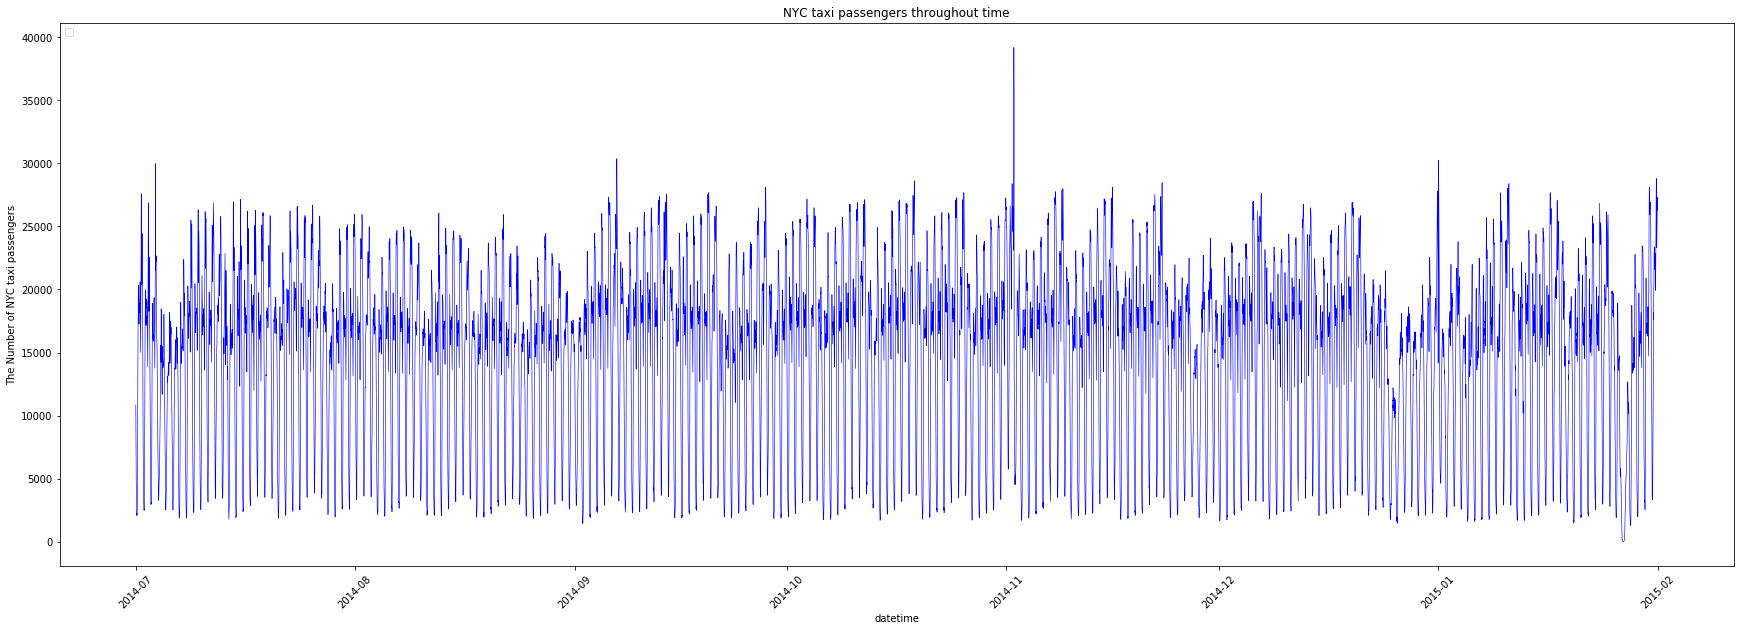

In [74]:
# change the type of timestamp column for plotting
df['datetime'] = pd.to_datetime(df['timestamp'])

# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(30, 10))

ax.plot(df['datetime'], df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

In [0]:
# the hours when people are awake (6:00-00:00)
df['hours'] = df['datetime'].dt.hour
df['awake'] = (((df['hours'] >= 6) & (df['hours'] <= 23)) | (df['hours'] == 0)).astype(int)

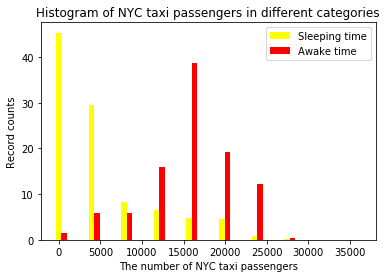

In [76]:
# creation of 2 distinct categories that seem useful (sleeping time and awake time)
df['categories'] = df['awake']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='yellow', label='Sleeping time')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='red', label ='Awake time')
ax.set_title('Histogram of NYC taxi passengers in different categories')

plt.xlabel('The number of NYC taxi passengers')
plt.ylabel('Record counts')
plt.legend()
plt.show()

In [77]:
#select and standardize data
data_n = df[['value', 'hours', 'awake']]
standard_scaler = preprocessing.StandardScaler()
np_scaled = standard_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

#important parameters and train/test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 200
testdatacut = testdatasize + unroll_length  + 1

#train data
x_train = data_n[0:-prediction_time-testdatacut].as_matrix()
y_train = data_n[prediction_time:-testdatacut  ][0].as_matrix()

#test data
x_test = data_n[0-testdatacut:-prediction_time].as_matrix()
y_test = data_n[prediction_time-testdatacut:  ][0].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [78]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (8918, 200, 3)
y_train (8918,)
x_test (1000, 200, 3)
y_test (1000,)


In [79]:
# Build the model
model = Sequential()

model.add(LSTM(
    input_shape=(x_train.shape[1], x_train.shape[-1]),
    output_dim=20,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    10,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))

model.compile(loss='mse', optimizer='rmsprop')

creating: createZooKerasSequential
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasLSTM
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createRMSprop
creating: createZooKerasMeanSquaredError


In [0]:
%%time
# Train the model
print("Training begins.")
model.fit(
    x_train,
    y_train,
    batch_size=1024,
    nb_epoch=20)
print("Training completed.")

Training begins.


In [0]:
# create the list of difference between prediction and test data
diff=[]
ratio=[]
predictions = model.predict(x_test)
p = predictions.collect()
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [0]:
print(p)

In [0]:
print(shape(y_test))

In [0]:
print(ratio)

In [0]:
# plot the predicted values and actual values (for the test data)
fig, axs = plt.subplots(figsize=(30,10))

axs.plot(p,color='red', label='predicted values')
axs.plot(y_test,color='blue', label='actual values')
axs.set_title('the predicted values and actual values (for the test data)')

plt.xlabel('test data index')
plt.ylabel('number of taxi passengers after scaling')
plt.legend(loc='upper left')
plt.show()

In [0]:

# An estimation of anomly population of the dataset
outliers_fraction = 0.01
# select the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)

number_of_outliers = int(outliers_fraction*len(diff))

threshold = diff.nlargest(number_of_outliers).min()

print("number_of_outliers = {0}, threshold = {1} ".format(number_of_outliers,threshold))

In [0]:
diff.head

In [0]:
# plot the difference and the threshold (for the test data)
fig, axs = plt.subplots(figsize=(30,10))

axs.plot(diff,color='blue', label='diff')
#axs.plot(p,color='black', label='predicted values')
#axs.plot(y_test,color='green', label='actual values')
axs.set_title('the difference between the predicted values and actual values with the threshold line')

plt.hlines(threshold, 0, 1000, color='red', label='threshold')
plt.xlabel('test data index')
plt.ylabel('difference value after scaling')
plt.legend(loc='upper left')
plt.show()

In [0]:
df.head()

In [0]:
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
# the training data part where we didn't predict anything (overfitting possible): no anomaly
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
last_train_data= (df['datetime'].tolist())[-testdatasize]
# add the data to the main
df_with_anomaly = df
df_with_anomaly['anomaly27'] = complement.append(test, ignore_index='True')

In [0]:
test.hist()

In [0]:
print(complement.array)

In [0]:
complement.head(2)

In [0]:
complement.describe()

In [0]:
print(" last_train_data = {0}".format(last_train_data))

In [0]:
df_with_anomaly.head(2)

In [0]:
df_with_anomaly.describe()

In [0]:
df[]

In [0]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(30, 10))

a = df_with_anomaly.loc[df_with_anomaly['anomaly27'] == 1, ['datetime', 'value']] #anomaly
ax.plot(df_with_anomaly['datetime'], df_with_anomaly['value'], color='blue', label='no anomaly value', linewidth=0.6)
ax.scatter(a['datetime'].tolist(),a['value'], color='red', label='anomalies value')
ax.set_title('the number of nyc taxi value throughout time (with anomalies scattered)')

max_value = df_with_anomaly['value'].max()
min_value = df_with_anomaly['value'].min()
plt.vlines(last_train_data, min_value, max_value, color='black', linestyles = "dashed", label='test begins')
plt.xlabel('datetime')
plt.xticks(rotation=45)
plt.ylabel('the number of nyc taxi value')
plt.legend(loc='upper left')
plt.show()

In [0]:
a.head(100)